In [1]:
from astropy.io import fits
from astropy.table import Table, join
import numpy as np
import pylab as plt
import random
from scipy import stats
from sklearn.neighbors import KDTree
import time
from sklearn.metrics import mean_squared_error
from astropy.cosmology import FlatLambdaCDM
from os import listdir
import desispec
import desispec.io
import speclite.filters
import scipy
from desitarget.targetmask import desi_mask, bgs_mask, mws_mask
from desitarget.cmx.cmx_targetmask import cmx_mask

In [2]:
## DATA ##
## I'm combining fastphot,fastspect, and ztile to make sure I use the same data everywhere ##

zall_path="/project/projectdirs/desi/spectro/redux/everest/zcatalog/ztile-main-bright-cumulative.fits"
data1=Table.read(zall_path,hdu=1)
needed1=["TARGETID","BGS_TARGET","SPECTYPE","DELTACHI2","Z","ZWARN","FIBER","PETAL_LOC","TILEID"]

fastspec_path = "/project/projectdirs/desi/spectro/fastspecfit/everest/catalogs/fastspec-everest-main-bright.fits"
data2=Table.read(fastspec_path,hdu=1)
needed2=["TARGETID","OII_3726_EW","OII_3729_EW","HGAMMA_EW","HBETA_EW","OIII_4959_EW","OIII_5007_EW","NII_6548_EW","HALPHA_EW","NII_6584_EW","SII_6716_EW","SII_6731_EW",\
        "OII_3726_EW_IVAR","OII_3729_EW_IVAR","HGAMMA_EW_IVAR","HBETA_EW_IVAR","OIII_4959_EW_IVAR","OIII_5007_EW_IVAR","NII_6548_EW_IVAR","HALPHA_EW_IVAR","NII_6584_EW_IVAR","SII_6716_EW_IVAR","SII_6731_EW_IVAR"]

file_path = "/project/projectdirs/desi/spectro/fastspecfit/everest/catalogs/fastphot-everest-main-bright.fits"
data3=Table.read(file_path,hdu=1)
needed3=["TARGETID","ABSMAG_SDSS_U","ABSMAG_SDSS_G","ABSMAG_SDSS_R","ABSMAG_SDSS_I","ABSMAG_SDSS_Z"]

data4=join(data1[needed1],data2[needed2],keys="TARGETID")
data=join(data4,data3[needed3],keys="TARGETID")

## Adding the sum of OII doublets to use them as a single line
data.add_column(data["OII_3726_EW"]+data["OII_3729_EW"],name='OII_DOUBLET_EW')
data.add_column(1/(data["OII_3726_EW_IVAR"]+data["OII_3729_EW_IVAR"]),name='OII_DOUBLET_EW_IVAR')

/tmp/ipykernel_34025/488371012.py:22: RuntimeWarning: divide by zero encountered in true_divide
  data.add_column(1/(data["OII_3726_EW_IVAR"]+data["OII_3729_EW_IVAR"]),name='OII_DOUBLET_EW_IVAR')


In [3]:
#data1.columns

In [4]:
lines=["OII_DOUBLET_EW","HGAMMA_EW","HBETA_EW","OIII_4959_EW","OIII_5007_EW","NII_6548_EW","HALPHA_EW","NII_6584_EW","SII_6716_EW","SII_6731_EW"]

N=len(data['TARGETID'])

snr_cut=1
# calculating snr for all lines and setting the snr cut as select_snr
snr_all=np.zeros([N,len(lines)])
snr_all[:,0]=data[lines[0]]*np.sqrt(data[lines[0]+"_IVAR"])

cut_Halpha=True
cut_all=False
for i in range(1,len(lines)):
    snr_all[:,i]=data[lines[i]]*np.sqrt(data[lines[i]+"_IVAR"])
    if cut_all:
        select_snr=select_snr*(snr_all[:,i]>snr_cut)
if cut_Halpha:
    select_snr=snr_all[:,6]>snr_cut
    
# calculating minimum redshift to have de-redshifted wavelengths be in the interval 3400,7000 A
w1=3400
w_min=3600
z_min=w_min/w1-1

# initial target selection
select=((data["BGS_TARGET"] & bgs_mask.mask("BGS_BRIGHT"))>0)*(data["SPECTYPE"]=="GALAXY")*(data["DELTACHI2"]>=25)\
        *(data["Z"]>z_min)*(data["Z"]<0.3)*(data["ZWARN"]==0)*select_snr


print(len(np.where(select==True)[0]))

/tmp/ipykernel_34025/1172066721.py:8: RuntimeWarning: invalid value encountered in multiply
  snr_all[:,0]=data[lines[0]]*np.sqrt(data[lines[0]+"_IVAR"])


450905


In [5]:
## getting first n points from target selection and storing them.

n=30*10**3

target_pos=np.where(select==True)[0]
target_ids=data["TARGETID"][select][:n]

fiber_ids=data["FIBER"][select][:n]
petal_locs=data["PETAL_LOC"][select][:n]
tile_ids=data["TILEID"][select][:n]
zs=data["Z"][select][:n]

target_lines=np.array(data[lines][select][:n]) 

run=2

# np.savez_compressed("/global/homes/a/ashodkh/results/target_lines_"+str(run)+".txt",target_lines)
# np.savez_compressed("/global/homes/a/ashodkh/results/zs_"+str(run)+".txt",zs)
# np.savez_compressed("/global/homes/a/ashodkh/results/target_ids_bin_"+str(run)+".txt",target_ids)

/tmp/ipykernel_34025/2791144835.py:47: RuntimeWarning: invalid value encountered in true_divide
  spectrum[second+first:first+len(wave_r)]=(flux_r[i2[second+first:first+len(wave_r)]]*inv_var_r[i2[second+first:first+len(wave_r)]]+flux_z[i3[second+first:first+len(wave_r)]]*inv_var_z[i3[second+first:first+len(wave_r)]])\
/tmp/ipykernel_34025/2791144835.py:44: RuntimeWarning: invalid value encountered in true_divide
  spectrum[first:len(wave_b)]=(flux_b[first:len(wave_b)]*inv_var_b[first:len(wave_b)]+flux_r[i2[first:len(wave_b)]]*inv_var_r[i2[first:len(wave_b)]])\


671.4329175949097


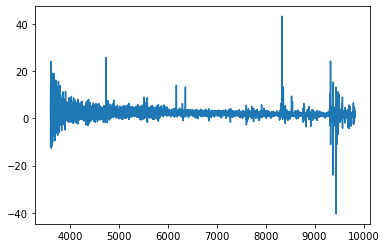

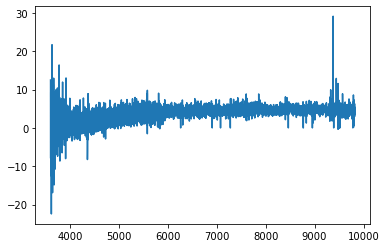

In [6]:
## getting spectra for n points by inverse variance weighting fluxes. Also de-redshifting wavelengths
nw=7781
spectra=np.zeros([n,nw])
redshifted_waves=np.zeros([n,nw])
tic=time.time()
for j in range(n):
    coadd_path="/project/projectdirs/desi/spectro/redux/everest/tiles/cumulative/"+str(tile_ids[j])
    a=listdir(coadd_path)[0]
    coadd_path="/project/projectdirs/desi/spectro/redux/everest/tiles/cumulative/"+str(tile_ids[j])+"/"+a
    coadd_path="/project/projectdirs/desi/spectro/redux/everest/tiles/cumulative/"+str(tile_ids[j])+"/"+a\
                +"/coadd-"+str(petal_locs[j])+"-"+str(tile_ids[j])+"-thru"+str(a)+".fits"


    test=fits.open(coadd_path)
    wave_b=test["B_WAVELENGTH"].data
    flux_b=test["B_FLUX"].data[fiber_ids[j]%500,:]
    inv_var_b=test["B_IVAR"].data[fiber_ids[j]%500,:]
    wave_r=test["R_WAVELENGTH"].data
    flux_r=test["R_FLUX"].data[fiber_ids[j]%500,:]
    inv_var_r=test["R_IVAR"].data[fiber_ids[j]%500,:]
    wave_z=test["Z_WAVELENGTH"].data
    flux_z=test["Z_FLUX"].data[fiber_ids[j]%500,:]
    inv_var_z=test["Z_IVAR"].data[fiber_ids[j]%500,:]

    first=np.where(abs(wave_b-wave_r[0])<10**-4)[0][0]
    second=np.where(abs(wave_r-wave_z[0])<10**-4)[0][0]

    nw=first+second+len(wave_z)

    spectrum=np.zeros(nw)

    i2=np.arange(nw)-first
    i3=np.arange(nw)-(second+first)

    wavelength=np.zeros(nw)
    
    wavelength[:first]=wave_b[:first]
    wavelength[first:len(wave_b)]=(wave_b[first:len(wave_b)]+wave_r[i2[first:len(wave_b)]])/2
    wavelength[len(wave_b):second+first]=wave_r[i2[len(wave_b):second+first]]
    wavelength[second+first:first+len(wave_r)]=(wave_r[i2[second+first:first+len(wave_r)]]+wave_z[i3[second+first:first+len(wave_r)]])/2
    wavelength[first+len(wave_r):]=wave_z[i3[first+len(wave_r):]]
        
    spectrum[:first]=flux_b[:first]  
    spectrum[first:len(wave_b)]=(flux_b[first:len(wave_b)]*inv_var_b[first:len(wave_b)]+flux_r[i2[first:len(wave_b)]]*inv_var_r[i2[first:len(wave_b)]])\
                                /(inv_var_b[first:len(wave_b)]+inv_var_r[i2[first:len(wave_b)]])
    spectrum[len(wave_b):second+first]=flux_r[i2[len(wave_b):second+first]]
    spectrum[second+first:first+len(wave_r)]=(flux_r[i2[second+first:first+len(wave_r)]]*inv_var_r[i2[second+first:first+len(wave_r)]]+flux_z[i3[second+first:first+len(wave_r)]]*inv_var_z[i3[second+first:first+len(wave_r)]])\
                    /(inv_var_r[i2[second+first:first+len(wave_r)]]+inv_var_z[i3[second+first:first+len(wave_r)]])
    spectrum[first+len(wave_r):]=flux_z[i3[first+len(wave_r):]]
   
    spectra[j,:]=spectrum[:]
    redshifted_waves[j,:]=wavelength[:]/(1+zs[j])
print(time.time()-tic)

plt.figure(1)
plt.plot(wavelength,spectra[0,:])
plt.figure(2)
plt.plot(wavelength,spectra[-1,:])

In [7]:
np.savez_compressed("/global/homes/a/ashodkh/results/spectra_"+str(run)+".txt",spectra)
np.savez_compressed("/global/homes/a/ashodkh/results/redshifted_waves_"+str(run)+".txt",redshifted_waves)